# LayoutLMv3 Training for SRE

In this notebook, we will try to train LayoutLMv3 for custom SER task dataset.

There will be not much commentaries in this notebook except the in-line comments.

By the end of this notebook you will see the result of the visualization.

In [ ]:
import gdown
gdown.download_folder('https://drive.google.com/drive/folders/15n6Mifgv83npPgg3bYwo8szx5tZTO10x?usp=sharing', quiet=True)
import zipfile

zip_file_path = '/content/mmocr_config/mmocr_training.zip'
extract_folder_path = '/content/mmocr_training/'

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the destination directory
    zip_ref.extractall(extract_folder_path)

print(f"Contents of {zip_file_path} have been extracted to {extract_folder_path}")
!cp -r "/content/mmocr_training" "./handwriting"

!unzip -qq "/content/mmocr_config/mmocr.zip" -d "/content/"
!mv "/content/content/mmocr" "/content/"
!rm -r "/content/content"

Contents of /content/mmocr_config/mmocr_training.zip have been extracted to /content/mmocr_training/


In [ ]:
!pip install accelerate datasets transformers seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=dbbdc99e86fc33f6d645932bebf8f61a2f9bdeabf2ff8c2f193cb776e260e09f
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
import json
from pathlib import Path
from typing import List

from torch.utils.data import Dataset
from transformers import AutoProcessor
from PIL import Image

LBL2ID = {
    "O": 0,
    "NUM": 1,
    "B-QUESTION": 2,
    "I-QUESTION": 3,
    "B-ANSWER": 4,
    "I-ANSWER": 5,
}
ID2LBL = {v: k for k, v in LBL2ID.items()}
LABEL_LIST = list(LBL2ID)

In [ ]:
def get_image_name(ls_image_path: Path) -> str:
    """
    Label studio will write the image file name in format of
    '{random_id}-{original_image_name}'. So we only want to
    get the original image name, since that is the name that
    we have.
    """
    name = ls_image_path.name
    name = name[(name.find("-") + 1):]
    return name

def load_annotation_json(annotation, train_dir, val_dir):
    with open(annotation, "r") as f:
        data_raw = json.load(f)
    for d in data_raw:
        d["ocr"] = get_image_name(Path(d["ocr"]))
    train_images = [p.name for p in train_dir.glob("*")]
    val_images = [p.name for p in val_dir.glob("*")]
    train_anno = [ann for ann in data_raw if ann["ocr"] in train_images]
    val_anno = [ann for ann in data_raw if ann["ocr"] in val_images]
    return train_anno, val_anno

def xywh2xyxy(xywh: List[float], img_width: int, img_height: int) -> List[int]:
    """
    Change bounding box format xywh normalized 0-100 to
    xyxy normalized 0-1000.
    """
    x, y, w, h = xywh
    x = x * 10
    y = y * 10
    w = w * 10
    h = h * 10
    return [
        int(x),
        int(y),
        int(x + w),
        int(y + h),
    ]

def extract_box(ls_box):
    xywh = [ls_box["x"], ls_box["y"], ls_box["width"], ls_box["height"]]
    return xywh2xyxy(xywh, ls_box["original_width"], ls_box["original_height"])

def extract_annotation_data(annotation, images_dir):
    converted_ann  = {}
    converted_ann["img_path"] = images_dir / annotation["ocr"]
    converted_ann["boxes"] = [extract_box(lbl) for lbl in annotation["label"]]
    converted_ann["words"] = annotation["transcription"]
    converted_ann["word_labels"] = [LBL2ID[lbl["labels"][0]] for lbl in annotation["label"]]
    return converted_ann

class CustomDataset(Dataset):
    def __init__(self, annotations, processor):
        self.annotations = annotations
        self.processor = processor
        self.dataset = [self._create_feature(ann) for ann in self.annotations]

    def _create_feature(self, ann):
        image = Image.open(ann["img_path"]).convert('RGB')
        encoding = self.processor(
            image,
            ann["words"],
            boxes=ann["boxes"],
            word_labels=ann["word_labels"],
            return_tensors="pt",
            truncation=True,
            padding="max_length",
        )
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

    def __getitem__(self, idx):
        return self.dataset[idx]

    def __len__(self):
        return len(self.dataset)

In [ ]:
ann_file = Path("/content/handwriting/annotation.json")
train_dir = Path("/content/handwriting/training")
val_dir = Path("/content/handwriting/test")

train_anns_ls, val_anns_ls =  load_annotation_json(ann_file, train_dir, val_dir)
train_anns = [extract_annotation_data(ann, train_dir) for ann in train_anns_ls]
val_anns = [extract_annotation_data(ann, val_dir) for ann in val_anns_ls]

processor = AutoProcessor.from_pretrained(
    "microsoft/layoutlmv3-base",
    apply_ocr=False,
)
train_dataset = CustomDataset(train_anns, processor)
val_dataset = CustomDataset(val_anns, processor)
combined_dataset = CustomDataset([*train_anns, *val_anns], processor)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [ ]:
train_dataset[0].keys()

dict_keys(['input_ids', 'attention_mask', 'bbox', 'labels', 'pixel_values'])

In [ ]:
for id, label in zip(val_dataset[0]["input_ids"], val_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
 5 1
 How 2
 are 3
 the 3
 common 3
 architectures 3
 of 3
 text 3
 detection 3
 and 3
 text 3
 recognition 3
 models 3
? 0
 Some 4
 common 5
 text 5
 detection 5
 architectures 5
 try 5
 to 5
 identify 5
 connected 5
 regions 5
 such 5
 as 5
 Connect 5
ed -100
 Component 5
 Analysis 5
 ( 5
CC -100
A -100
) -100
. 0
 Some 5
 also 5
 use 5
 edge 5
 - 0
 based 5
 detection 5
. 0
 Some 4
 common 5
 text 5
 recognition 5
 architectures 5
 use 5
 recurrent 5
 network 5
 to 5
 analyze 5
 text 5
 sequences 5
 such 5
 as 5
 L 5
ST -100
M -100
 and 5
 attention 5
 model 5
. 0
 Some 5
 also 5
 use 5
 non 5
 - 0
 recurring 5
 neural 5
 network 5
 ( 0
 which 5
 means 5
 analyzing 5
 the 5
 whole 5
 texts 5
 at 5
 once 5
 ) 0
 such 5
 as 5
 transform 5
ers -100
. 0
</s> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -10

## Training

In [ ]:
from datasets import load_metric

metric = load_metric("seqeval")

<ipython-input-8-edef154daec7>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [LABEL_LIST[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [LABEL_LIST[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [ ]:
from transformers import LayoutLMv3ForTokenClassification, TrainingArguments, Trainer
from transformers.data.data_collator import default_data_collator

repo_name = "ser-model-microsoft"

model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    id2label=ID2LBL,
    label2id=LBL2ID,
)

training_args = TrainingArguments(
    output_dir=repo_name,
    max_steps=100,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=1e-5,
    evaluation_strategy="steps",
    eval_steps=10,
    metric_for_best_model="f1",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NUM seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=100, training_loss=0.3345348358154297, metrics={'train_runtime': 74.9776, 'train_samples_per_second': 2.667, 'train_steps_per_second': 1.334, 'total_flos': 52720596172800.0, 'train_loss': 0.3345348358154297, 'epoch': 50.0})

In [ ]:
# Compute the evaluation metrics
trainer.evaluate()

{'eval_loss': 0.2762126326560974,
 'eval_precision': 0.6,
 'eval_recall': 0.9,
 'eval_f1': 0.7200000000000001,
 'eval_accuracy': 0.925,
 'eval_runtime': 0.0793,
 'eval_samples_per_second': 12.616,
 'eval_steps_per_second': 12.616,
 'epoch': 50.0}

In [ ]:
# Log in to your Hugging Face account
# Get your API token here https://huggingface.co/settings/token
from huggingface_hub import login

login(token='hidden')

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
# Upload the model to the Hub
trainer.push_to_hub()

events.out.tfevents.1706317951.db74735e983c.649.0:   0%|          | 0.00/9.78k [00:00<?, ?B/s]

events.out.tfevents.1706318026.db74735e983c.649.1:   0%|          | 0.00/551 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/aruca/ser-model-microsoft/commit/6bc6af7effd0348d89cc4f11e6cb3262bb93fe2f', commit_message='End of training', commit_description='', oid='6bc6af7effd0348d89cc4f11e6cb3262bb93fe2f', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 14.2 MB/s eta 0:00:00


In [ ]:
import cv2
import easyocr
import numpy as np
import torch
from google.colab.patches import cv2_imshow
from PIL import Image, ImageDraw, ImageFont, ImageOps
from transformers import AutoProcessor, LayoutLMv3ForTokenClassification

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ocr_reader = easyocr.Reader(["en"])

ser_processor = AutoProcessor.from_pretrained(
    "aruca/ser-model-microsoft", apply_ocr=False
)
ser_model = LayoutLMv3ForTokenClassification.from_pretrained(
    "aruca/ser-model-microsoft"
)
ser_model.to(device)
id2label = ser_model.config.id2label

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import os

!mkdir "/content/work_dir"
!mkdir "/content/work_dir2"

!mv "/content/mmocr_config/epoch_50_det.pth" "/content/work_dir"
!mv "/content/mmocr_config/epoch_50_rec.pth" "/content/work_dir2"

os.rename('/content/work_dir/epoch_50_det.pth', '/content/work_dir/epoch_50.pth')
os.rename('/content/work_dir2/epoch_50_rec.pth', '/content/work_dir2/epoch_50.pth')

In [ ]:
### Text Detections
DBNET_IC15 = {
    "config": "/content/mmocr/configs/textdet/dbnet/dbnet_resnet50-dcnv2_fpnc_1200e_icdar2015.py",
    "weights": "/content/work_dir/epoch_50.pth"
}

### Text Recognition
SVTR_SYNTH = {
    "config": "/content/mmocr/configs/textrecog/svtr/svtr-base_20e_st_mj.py",
    "weights": "/content/work_dir2/epoch_50.pth"
}

In [ ]:
!pip install torch==1.13.1+cu117 \
  torchvision==0.14.1+cu117 \
  --extra-index-url https://download.pytorch.org/whl/cu117
!pip install -U openmim
!mim install "mmengine>=0.7.1,<1.1.0"
!mim install "mmcv>=2.0.0rc4,<2.1.0"
!mim install "mmdet>=3.0.0rc5,<3.2.0"
#!git clone https://github.com/open-mmlab/mmocr.git     <- we already loaded our mmocr config file above
!cd mmocr && pip install -v -e .

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 614.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 44.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu121
    Uninstalling torch-2.1.0+cu121:
      Successfully uninstalled torch-2.1.0+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.16.0+cu121
    Uninstalling torchvision-0.16.0+cu121:
      Successfully uninstalled torchvision-0.16.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu121 requires torch==2.1.0, but you have torch 1.13.1+cu117 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 1.13.1+cu117 which is incompatible.
torchtext 0.16.0 requires 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 21.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.1/953.1 kB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

Looking in links: https://download.openmmlab.com/mmcv/dist/cu117/torch1.13.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.7/451.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 8.2 MB/s eta 0:00:00
Looking in links: https://download.openmmlab.com/mmcv/dist/cu117/torch1.13.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 MB 5.0 MB/s eta 0:00:00
Looking in links: https://download.openmmlab.com/mmcv/dist/cu117/torch1.13.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.4 MB/s eta 0:00:00
Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
Obtaining file:///content/mmocr
  Running command python setup.py egg_info
  running egg_info
  creating /tmp/pip-pip-egg-info-5jjnu99e/mmocr.egg-info
  writing manifest file '/tmp/pip-pip-egg-info-5jjnu99e/mmocr.egg-info/SOURCES.txt'
  writing manifest file '/tmp/pip-pip-egg-info-5jjnu99e/mmocr.egg-info/SOURCES.txt'
  Preparing me

In [ ]:
import cv2
import matplotlib.pyplot as plt
import mmcv
import numpy as np
from matplotlib.patches import Rectangle
from mmocr.apis import TextDetInferencer, TextRecInferencer

In [ ]:
from PIL import Image, ImageOps

IMAGE_TEST = "/content/mmocr_training/test/q5.jpeg"
DET_MODEL = DBNET_IC15
TARGET_WIDTH = 1024  # Set your target width

image = Image.open(IMAGE_TEST)
image = ImageOps.exif_transpose(image)
wpercent = TARGET_WIDTH / image.size[0]
hsize = int(image.size[1] * wpercent)
image = image.resize((TARGET_WIDTH, hsize), Image.LANCZOS)
width, height = image.size

# Convert the resized image back to numpy array
resized_img = mmcv.rgb2bgr(np.array(image))

# Perform text detection on the resized image
inferencer = TextDetInferencer(model=DET_MODEL["config"], weights=DET_MODEL["weights"])
det_result = inferencer(resized_img)
polys_raw = det_result["predictions"][0]["polygons"]

Loads checkpoint by local backend from path: /content/work_dir/epoch_50.pth
01/27 09:44:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
01/27 09:44:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
01/27 09:44:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
01/27 09:44:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
01/27 09:44:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
01/27 09:44:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
01/27 09:44:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
01/27 09:44:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
01/27 09:44:46 - mmengine - INFO - ModulatedDeformCo

Output()

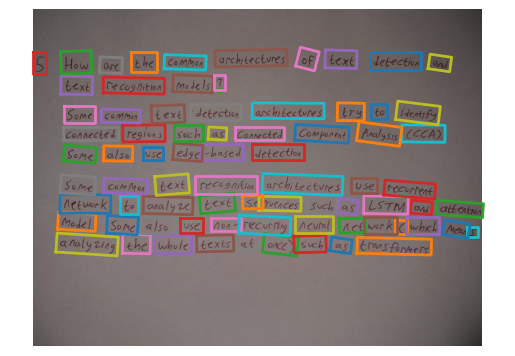

In [ ]:
polys = []
for poly in polys_raw:
  c = np.array(poly).astype(int).reshape((-1, 2))
  rect = cv2.minAreaRect(c)
  box = cv2.boxPoints(rect)
  polys.append(box)

fig, ax = plt.subplots()
ax.imshow(resized_img)
for poly in polys:
  c = np.concatenate((poly, poly[0].reshape((-1, 2))))
  ax.plot(c[:, 0], c[:, 1], linewidth=2)
ax.axis("off")
plt.show()

In [ ]:
tolerance = 30  # You can adjust this value based on your needs

rows = {}
for poly in polys:
    y = np.mean(poly[:, 1])  # Use mean y-coordinate as the key
    added_to_existing_row = False

    # Check if the polygon can be added to an existing row within tolerance
    for existing_row_key in rows:
        if abs(y - existing_row_key) < tolerance:
            rows[existing_row_key].append(poly)
            added_to_existing_row = True
            break

    # If not added to an existing row, create a new row
    if not added_to_existing_row:
        rows[y] = [poly]

# Sort within each row based on x-coordinates
for row_key in rows:
    rows[row_key] = sorted(rows[row_key], key=lambda poly: poly[0, 0])

# Sort rows based on the y-coordinates of the first polygon in each row
sorted_rows = sorted(rows.items(), key=lambda item: item[0])

combined = []
# Now, sorted_rows contains the grouped and sorted polygons
for row_key, row_polys in sorted_rows:
    for poly in row_polys:
        combined.append(poly)

polys=combined.copy()

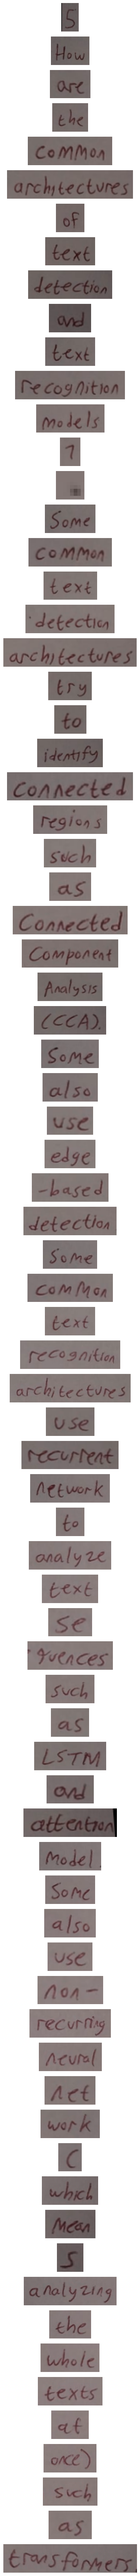

In [ ]:
def organize_points(rect):
  """
  Sort 4 vertices polygon into the same order
  [top-left, top-right, bottom-right, bottom-left]
  """
  # sort points based on the x coordinate
  # so the order now [left-1, left-2, right-1, right-2]
  # we don't know which one is top or bottom yet
  points = sorted(list(rect), key=lambda x: x[0])
  # for 2 left points
  # the point with smaller y become top-left
  if points[1][1] > points[0][1]:
      index_1 = 0
      index_4 = 1
  else:
      index_1 = 1
      index_4 = 0
  # for 2 right points
  # the point with smaller y become top-right
  if points[3][1] > points[2][1]:
      index_2 = 2
      index_3 = 3
  else:
      index_2 = 3
      index_3 = 2

  return np.array([
      points[index_1], points[index_2], points[index_3], points[index_4]
  ])

def extract_text_image(rect, img):
  """
  Given 4 vertices polygon, crop the image using that
  polygon, and transform the crop so that it is flat.
  """
  # get the top-left, top-right, bottom-right, and bottom-left points.
  rect = organize_points(rect)
  tl, tr, br, bl = rect

  # determine the flattened image width,
  # which is equal to the largest bottom/top side of the polygon
  widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
  widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
  maxWidth = max(int(widthA), int(widthB))

  # determine the flattened image height,
  # which is equal to the largest left/right side of the polygon
  heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
  heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
  maxHeight = max(int(heightA), int(heightB))

  # create the 4 vertices polygon after transformation
  dst = np.array(
    [
      [0, 0],
      [maxWidth - 1, 0],
      [maxWidth - 1, maxHeight - 1],
      [0, maxHeight - 1],
    ],
    dtype=np.float32,
  )
  # do the transformation
  M = cv2.getPerspectiveTransform(rect, dst)
  return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

text_images = [extract_text_image(poly, resized_img) for poly in polys]
fig, axs = plt.subplots(len(text_images), figsize=(5, len(text_images)*1), tight_layout=True)
for i, txt_img in enumerate(text_images):
  axs[i].imshow(txt_img)
  axs[i].axis("off")
plt.show()

In [ ]:
REC_MODEL = SVTR_SYNTH
inferencer = TextRecInferencer(model=REC_MODEL["config"], weights=REC_MODEL["weights"])

text_images = []
texts = []
for poly in polys:
  poly_arr = np.array(poly).reshape((-1, 2)).astype(np.float32)
  txt_img = extract_text_image(poly_arr, resized_img)
  rec_result = inferencer(txt_img)
  text_images.append(txt_img)
  texts.append(rec_result["predictions"][0]["text"])

Loads checkpoint by local backend from path: /content/work_dir2/epoch_50.pth


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

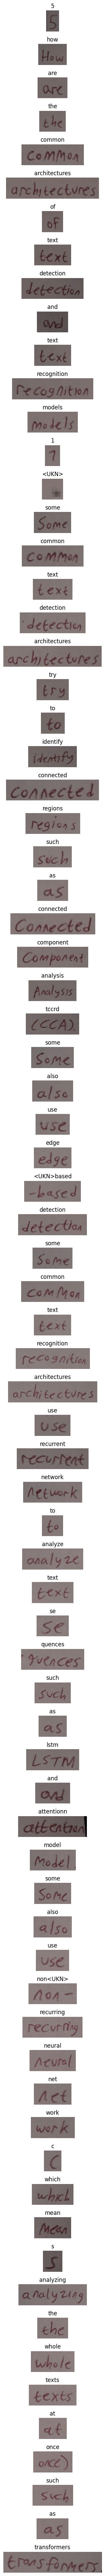

In [ ]:
fig, axs = plt.subplots(len(texts), figsize=(5, len(texts)*1), tight_layout=True)
for i, txt in enumerate(texts):
  axs[i].imshow(text_images[i])
  axs[i].set_title(txt)
  axs[i].axis("off")
plt.show()

In [ ]:
# Combine polys and texts into ocr_results format
combined_results = []
for poly, text in zip(polys, texts):
    # Extract coordinates from poly
    coordinates = poly.astype(int).tolist()
    # Create the entry in the format of ocr_results
    entry = (coordinates, text, 1.0)
    combined_results.append(entry)

combined_results

[([[-1, 97], [30, 97], [30, 148], [-1, 148]], '5', 1.0),
 ([[63, 96], [132, 93], [134, 145], [64, 147]], 'how', 1.0),
 ([[151, 144], [153, 107], [204, 109], [202, 146]], 'are', 1.0),
 ([[222, 95], [281, 95], [281, 142], [222, 142]], 'the', 1.0),
 ([[298, 134], [300, 103], [395, 106], [394, 138]], 'common', 1.0),
 ([[415, 94], [579, 90], [580, 128], [415, 131]], 'architectures', 1.0),
 ([[599, 129], [610, 86], [653, 97], [642, 140]], 'of', 1.0),
 ([[665, 132], [667, 92], [739, 94], [738, 135]], 'text', 1.0),
 ([[768, 97], [886, 97], [886, 137], [768, 137]], 'detection', 1.0),
 ([[901, 135], [905, 101], [955, 109], [950, 142]], 'and', 1.0),
 ([[63, 193], [64, 152], [136, 153], [135, 194]], 'text', 1.0),
 ([[160, 190], [160, 153], [300, 157], [299, 193]], 'recognition', 1.0),
 ([[318, 186], [320, 149], [411, 152], [410, 190]], 'models', 1.0),
 ([[412, 149], [437, 149], [437, 184], [412, 184]], '1', 1.0),
 ([[421, 181], [429, 181], [429, 189], [421, 189]], '<UKN>', 1.0),
 ([[70, 219], [141

In [ ]:
def normalize_box(bbox, width, height):
    # xyxy
    return [
        int(bbox[0] / width * 1000),
        int(bbox[1] / height * 1000),
        int(bbox[2] / width * 1000),
        int(bbox[3] / height * 1000),
    ]

def prepare_bbox(bbox, width, height):
    bbox_np = np.array(bbox).reshape((-1, 2))
    x1, x2 = np.min(bbox_np[:, 0]), np.max(bbox_np[:, 0])
    y1, y2 = np.min(bbox_np[:, 1]), np.max(bbox_np[:, 1])
    return normalize_box([x1, y1, x2, y2], width, height)

bboxes = [prepare_bbox(res[0], width, height) for res in combined_results]
texts = [res[1] for res in combined_results]

In [ ]:
encoding = ser_processor(
    image,
    texts,
    boxes=bboxes,
    return_offsets_mapping=True,
    return_tensors="pt"
)
offset_mapping = encoding.pop('offset_mapping')

for k,v in encoding.items():
  encoding[k] = v.to(device)

In [ ]:
outputs = ser_model(**encoding)
# get the label with max logits
predictions = outputs.logits.argmax(-1).squeeze().tolist()
# get the bounding box
token_boxes = encoding.bbox.squeeze().tolist()

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [ ]:
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

# filter out predictions and boxes that are subword
is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0
true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

--2024-01-27 09:48:31--  https://ultralytics.com/assets/Arial.ttf
Resolving ultralytics.com (ultralytics.com)... 75.2.70.75, 99.83.190.102
Connecting to ultralytics.com (ultralytics.com)|75.2.70.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ultralytics.com/assets/Arial.ttf [following]
--2024-01-27 09:48:32--  https://www.ultralytics.com/assets/Arial.ttf
Resolving www.ultralytics.com (www.ultralytics.com)... 104.18.0.125, 104.18.1.125, 2606:4700::6812:17d, ...
Connecting to www.ultralytics.com (www.ultralytics.com)|104.18.0.125|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/ultralytics/yolov5/releases/download/v1.0/Arial.ttf [following]
--2024-01-27 09:48:32--  https://github.com/ultralytics/yolov5/releases/download/v1.0/Arial.ttf
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent

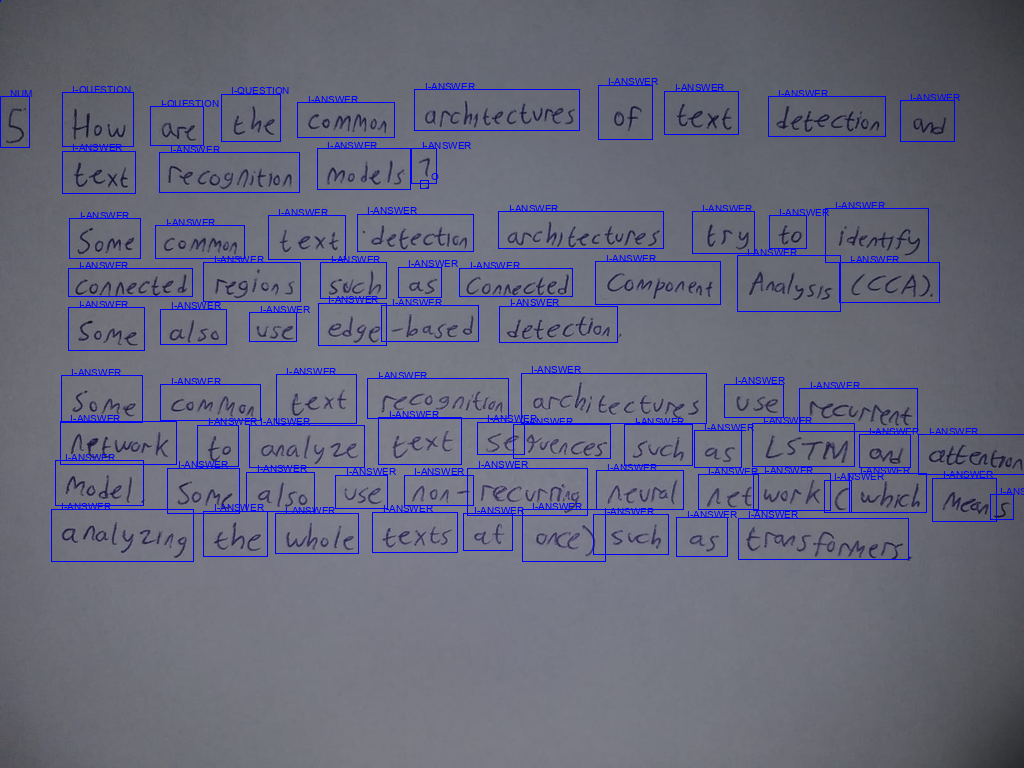

In [ ]:
!wget https://ultralytics.com/assets/Arial.ttf

vis = image.copy()
draw = ImageDraw.Draw(vis)
font = ImageFont.truetype("Arial.ttf", 10)
for prediction, box in zip(true_predictions, true_boxes):
    draw.rectangle(box, outline="blue")
    draw.text((box[0]+10, box[1]-10), text=prediction, font=font, fill="blue")

vis